https://adaresearch.wordpress.com/2024/08/07/vpint2_cloud_removal/

## mount bucket

In [1]:
## mount bucket
!gcsfuse vpint_demo /home/walter_littor_al/vpint-data

{"timestamp":{"seconds":1756484547,"nanos":32618906},"severity":"INFO","message":"Start gcsfuse/3.1.0 (Go version go1.24.0) for app \"\" using mount point: /home/walter_littor_al/vpint-data\n"}
{"timestamp":{"seconds":1756484547,"nanos":32662454},"severity":"INFO","message":"GCSFuse config","config":{"AppName":"","CacheDir":"","Debug":{"ExitOnInvariantViolation":false,"Fuse":false,"Gcs":false,"LogMutex":false},"DisableAutoconfig":false,"EnableAtomicRenameObject":true,"EnableGoogleLibAuth":false,"EnableHns":true,"EnableNewReader":false,"FileCache":{"CacheFileForRangeRead":false,"DownloadChunkSizeMb":200,"EnableCrc":false,"EnableODirect":false,"EnableParallelDownloads":false,"ExperimentalExcludeRegex":"","ExperimentalParallelDownloadsDefaultOn":true,"MaxParallelDownloads":16,"MaxSizeMb":-1,"ParallelDownloadsPerFile":16,"WriteBufferSize":4194304},"FileSystem":{"DirMode":"755","DisableParallelDirops":false,"ExperimentalEnableDentryCache":false,"ExperimentalEnableReaddirplus":false,"FileMod

## import dependencies

In [2]:
import sys
import os

# Add the parent VPint directory to the path so Python can find the package
sys.path.append('/home/walter_littor_al/VPint')

# Now import from the VPint package
from VPint.VPint2 import VPint2_interpolator
from VPint.utils.EO_utils import load_product, load_product_windowed, normalise_and_visualise, normalise_and_visualise_single

import matplotlib.pyplot as plt
import numpy as np

target_path = "/home/walter_littor_al/vpint-data/TB_S2B_MSIL2A_20250729T051649_N0511_R062_T43NCA_20250729T085641.SAFE.zip"
features_path = "/home/walter_littor_al/vpint-data/FT_S2C_MSIL1C_20250823T051711_N0511_R062_T43NCA_20250823T085630.SAFE.zip"

In [3]:
# Add the parent SEnSeIv2 directory to the path so Python can find the package
sys.path.append('/home/walter_littor_al/SEnSeIv2')
# add senseiv2 for better masking
from senseiv2.inference import CloudMask
from senseiv2.utils import get_model_files
from senseiv2.constants import SENTINEL2_BANDS,SENTINEL2_DESCRIPTORS,LANDSAT89_BANDS,LANDSAT89_DESCRIPTORS
from skimage.transform import resize  # More specific import to avoid conflicts

## load full images

In [4]:
# full_target = load_product(target_path)
# full_features = load_product(features_path)

# normalise_and_visualise(full_target)
# normalise_and_visualise(full_features)

## calculate cloud masks

In [5]:
# Set based on your runtime (cpu-only will run but is significantly slower)
DEVICE = 'cuda'

# Pick pre-trained model from https://huggingface.co/aliFrancis/SEnSeIv2
model_name = 'SEnSeIv2-SegFormerB2-alldata-ambiguous'
config, weights = get_model_files(model_name)

# Lots of options in the kwargs for different settings
model = CloudMask(config, weights, verbose=True, categorise=True, device=DEVICE)

# We will use all available bands from target
band_names = [b['name'] for b in SENTINEL2_BANDS if b['name'] in ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']]

/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Preprocess the in-memory VPint S2 target (HxWxC uint16) into SEnSeIv2 input (CxHxW float32)
# Handles small windows by resizing to 1068x1068 for the model.
# Preprocess a small windowed S2 array (HxWxC uint16) -> (CxHxW float32) with descriptors
def preprocess_s2_window(target_arr, band_names=None, min_size=1068):
    vpint_index = {
        'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3,
        'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7,
        'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11,
    }
    if band_names is None:
        band_names = list(vpint_index.keys())
    band_names = [b for b in band_names if b in vpint_index]
    band_idxs = [vpint_index[b] for b in band_names]
    h, w = target_arr.shape[:2]
    sub = target_arr[..., band_idxs].astype('float32')
    sub = (sub / 10000.0).clip(0.0, 1.0)
    if h < min_size or w < min_size:
        from skimage.transform import resize
        im_resized = np.zeros((len(band_idxs), min_size, min_size), dtype='float32')
        for i in range(len(band_idxs)):
            im_resized[i, ...] = resize(sub[..., i], (min_size, min_size), order=1, preserve_range=True, anti_aliasing=False)
        im = im_resized
    else:
        im = sub.transpose(2, 0, 1)
    s2_desc_by_name = {b['name']: d for b, d in zip(SENTINEL2_BANDS, SENTINEL2_DESCRIPTORS)}
    descriptors = [s2_desc_by_name[b] for b in band_names]
    return im, descriptors


def preprocess_s2(target_arr, band_names=None, min_size=1068):
    # VPint EO_utils.load_product returns bands in this order (indices):
    # 0:B01, 1:B02, 2:B03, 3:B04, 4:B05, 5:B06, 6:B07, 7:B08, 8:B8A, 9:B09, 10:B11, 11:B12
    vpint_index = {
        'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3,
        'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7,
        'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11,
    }

    # Default to all available VPint bands (note: B10 is not present in VPint default load)
    if band_names is None:
        band_names = list(vpint_index.keys())

    # Filter to bands we actually have in target_arr
    band_names = [b for b in band_names if b in vpint_index]
    band_idxs = [vpint_index[b] for b in band_names]

    h, w = target_arr.shape[:2]
    sub = target_arr[..., band_idxs].astype('float32')

    # Scale to 0..1 reflectance
    sub = (sub / 10000.0).clip(0.0, 1.0)

    # If small window, upsize to the model's expected minimum resolution
    if h < min_size or w < min_size:
        from skimage.transform import resize
        im_resized = np.zeros((len(band_idxs), min_size, min_size), dtype='float32')
        for i in range(len(band_idxs)):
            im_resized[i, ...] = resize(
                sub[..., i], (min_size, min_size), order=1, preserve_range=True, anti_aliasing=False
            )
        im = im_resized
    else:
        # HxWxC -> CxHxW
        im = sub.transpose(2, 0, 1)

    # Match descriptors to the selected bands (by name)
    s2_desc_by_name = {b['name']: d for b, d in zip(SENTINEL2_BANDS, SENTINEL2_DESCRIPTORS)}
    descriptors = [s2_desc_by_name[b] for b in band_names]

    return im, descriptors


# Convert mask tensor to categorical if needed
def convert_to_colormap(mask, style='4-class', categorised=True):
    m = mask
    if not categorised:
        m = np.argmax(m, axis=0)
    out = np.zeros((m.shape[0], m.shape[1], 4))
    if style == 'cloud-noncloud':
        out[m == 1] = [1, 1, 0, 0.3]  # Cloud
    if style == '4-class':
        out[m == 1] = [1, 0.9, 0, 0.3]  # Thick
        out[m == 2] = [0.5, 1, 0.1, 0.3]  # Thin
        out[m == 3] = [1, 0, 0, 0.3]  # Shadow
    if style == '7-class':
        out[m == 1] = [0, 0, 1, 0.3]  # Water
        out[m == 2] = [1, 0, 1, 0.3]  # Snow
        out[m == 3] = [0.5, 1, 0.1, 0.3]  # Thin
        out[m == 4] = [1, 0.9, 0, 0.3]  # Thick
        out[m == 5] = [1, 0, 0, 0.3]  # Shadow
    return out

## back to vpint

In [17]:
# Test with larger offset values to confirm the fix works
# Window parameters for extracting a patch from the satellite image
y_size = 256#1068   # Height of the window (pixels)
x_size = 256#1068    # Width of the window (pixels)

# Window position (top-left corner coordinates) - using the original problematic values
y_offset = 50   # Vertical position from top edge
x_offset = 50   # Horizontal position from left edge

print(f"✅ Extracting {y_size}x{x_size} window at position ({x_offset}, {y_offset})")

# Perform the windowed data loading
target = load_product_windowed(target_path, y_size, x_size, y_offset, x_offset)
features = load_product_windowed(features_path, y_size, x_size, y_offset, x_offset)

# # Visualise
# normalise_and_visualise(target)
# normalise_and_visualise(features)

✅ Extracting 256x256 window at position (50, 50)


In [18]:
# Create a mask for the windowed target using senseiv2
im, descriptors = preprocess_s2_window(target, band_names)
cloud_mask = model(im, descriptors=descriptors, stride=357)

Predicting patches: 100%|██████████| 9/9 [00:01<00:00,  8.22it/s]

Postprocessing mask with classes: Clear/Thick/Thin/Shadow


## note

need to figure out how to format the fancy cloud mask so it works like the simple mask

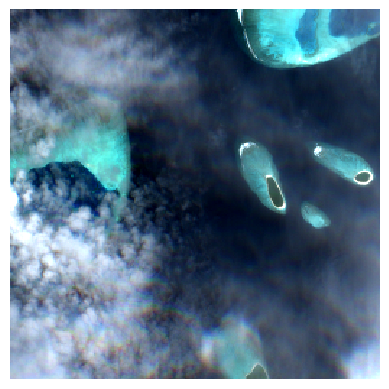

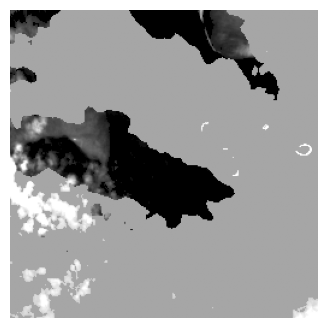

In [22]:
# convert  masks for imputation
thick_mask = ((cloud_mask != 2)) * 100
allcloud_mask = ((cloud_mask != 2) & (cloud_mask != 1)) * 100
full_mask = ((cloud_mask < 1)) * 100

# get the default mask from imagery
def_mask = load_product_windowed(target_path, y_size, x_size, y_offset, x_offset, keep_bands=["CLD"], bands_20m={"CLD":0})[:,:,0]

normalise_and_visualise(target)
# Visual preview of thresholded mask
plt.figure(figsize=(4,4))
plt.imshow(def_mask, cmap='gray')
plt.axis('off')
plt.show()

## inspect mask

Cloud mask shape: (1068, 1068) dtype: int64
Value range: 0.0 to 3.0
Mean value: 1.2123381587622213
Top mask values:
  1: 807505 px (70.80%)
  2: 252914 px (22.17%)
  0: 57042 px (5.00%)
  3: 23163 px (2.03%)


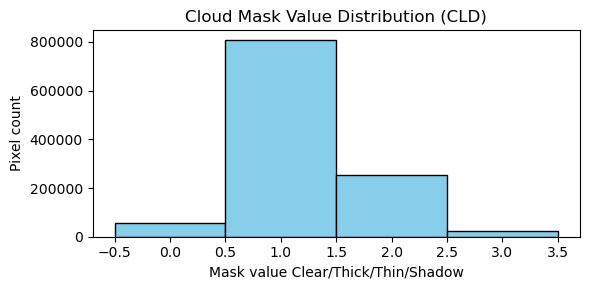

Cloud coverage (mask = 1): 807505 px (70.80%)


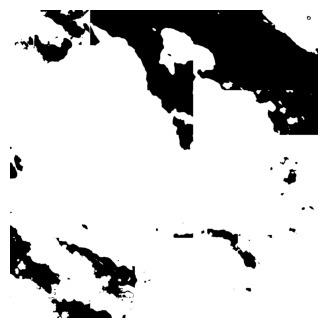

In [ ]:
# print("Cloud mask shape:", cloud_mask.shape, "dtype:", cloud_mask.dtype)
# print("Value range:", float(np.min(cloud_mask)), "to", float(np.max(cloud_mask)))
# print("Mean value:", float(np.mean(cloud_mask)))

# # Unique values sample (up to 10 entries)
# vals, cnts = np.unique(cloud_mask, return_counts=True)
# idx = np.argsort(cnts)[::-1]
# print("Top mask values:")
# for v, c in zip(vals[idx][:10], cnts[idx][:10]):
#     print(f"  {int(v)}: {int(c)} px ({c/cloud_mask.size:.2%})")

# # Histogram of mask values
# plt.figure(figsize=(6,3))
# plt.hist(cloud_mask.ravel(), bins=np.arange(np.min(cloud_mask), np.max(cloud_mask)+2)-0.5, color='skyblue', edgecolor='black')
# plt.title('Cloud Mask Value Distribution (CLD)')
# plt.xlabel('Mask value Clear/Thick/Thin/Shadow')
# plt.ylabel('Pixel count')
# plt.tight_layout()
# plt.show()

## run imputation

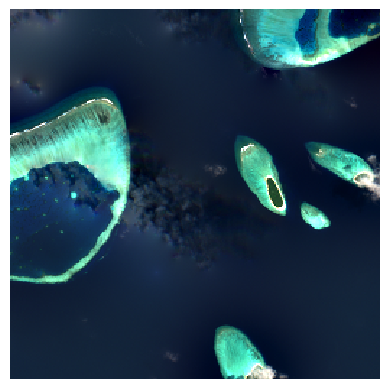

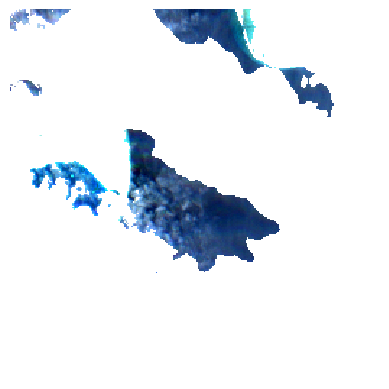

In [20]:
VPint2 = VPint2_interpolator(target, features, mask=def_mask, bands_first=False, threshold=10) # Set bands_first to True if your data is C x H x W instead of H x W x C
pred = VPint2.run()
normalise_and_visualise(pred)
normalise_and_visualise(VPint2.target)

## tuning imputation results

In [ ]:
# # adding a simple buffer

# VPint2 = VPint2_interpolator(target, features, mask=allcloud_mask, buffer_mask=True, mask_buffer_size=5, bands_first=False, threshold=10) 
# normalise_and_visualise(VPint2.target) # Visualise the buffered mask
# pred = VPint2.run() # Run the algorithm

# normalise_and_visualise(pred)

In [ ]:
# # running with smart auto-configuration

# VPint2 = VPint2_interpolator(target, features, mask=allcloud_mask, buffer_mask=True, mask_buffer_size=5, bands_first=False, threshold=10) 
# # Run the algorithm with automatically configured extensions
# pred = VPint2.run(resistance=True, prioritise_identity=True, clip_val=10000,
#                     auto_adapt=True, auto_adaptation_epochs=10, auto_adaptation_max_iter=100, auto_adaptation_strategy='random', auto_adaptation_proportion=0.8)

# normalise_and_visualise(pred)

## unmount

In [23]:
!fusermount -u /home/walter_littor_al/vpint-data